# PlantSpy 2- Classification Type de maladie Grapes

## Importer les librairies et connection au Drive

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
import pathlib
from PIL import Image 
from sklearn.model_selection import train_test_split
%matplotlib inline

from matplotlib import cm

from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential
from tensorflow.keras import callbacks

from tensorflow.keras.applications.vgg16 import VGG16


from sklearn import metrics # Pour évaluer les modèles

import itertools # Pour créer des iterateurs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Recuperation des donnees:


#### Train Dataset

In [ ]:
# folder_path = "/content/drive/MyDrive/Kaggle/new-plant-diseases-dataset/train/"
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/train/"

X_train0=[]
y_train0=[]

width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      if ("Grape" in repertoire) : 
        chemin=folder_path+repertoire
        for images in os.listdir(chemin):
          img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
          img_resized = cv2.resize(img, (width,height))
          X_train0.append(np.array(img_resized))
          y_train0.append(repertoire.split('___')[1])   # On recupere le type de maladie seulement 

In [ ]:
X_train0 = np.array(X_train0)
X_train0 = X_train0.astype('float32')


In [ ]:
y_train0= np.array(y_train0)

In [ ]:
X_train0.shape

(7222, 100, 100, 3)

In [ ]:
print(pd.DataFrame(y_train0).value_counts())

Esca_(Black_Measles)                  1920
Black_rot                             1888
Leaf_blight_(Isariopsis_Leaf_Spot)    1722
healthy                               1692
dtype: int64


#### Valid Dataset

In [ ]:
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/valid/"

X_valid0=[]
y_valid0=[]

width = 100
height = 100 # 

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      if ("Grape" in repertoire) :
        chemin=folder_path+repertoire
        for images in os.listdir(chemin):
          img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
          img_resized = cv2.resize(img, (width,height))
          X_valid0.append(np.array(img_resized))
          y_valid0.append(repertoire.split('___')[1])   # On recupere le type de maladie seulement 


In [ ]:
X_valid0= np.array(X_valid0)
X_valid0 = X_valid0.astype('float32')

y_valid0= np.array(y_valid0)

In [ ]:
X_valid0.shape

(1382, 100, 100, 3)

In [ ]:
pd.DataFrame(y_valid0).value_counts()

Esca_(Black_Measles)                  480
Black_rot                             472
Leaf_blight_(Isariopsis_Leaf_Spot)    430
healthy                               423
dtype: int64

## DataViz

In [ ]:
# Diviser les pixels des données X_train et X_test par 255 afin qu'ils soient compris entre 0 et 1
X_train = X_train0 / 255
X_valid = X_valid0 / 255

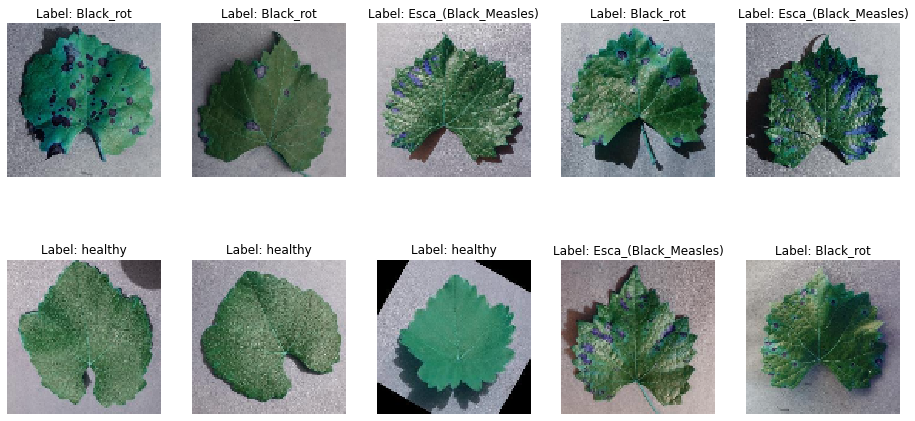

In [ ]:
plt.subplots(2, 5, figsize=(16, 8))

j = 1

for i in np.random.choice(np.arange(0, len(X_train)), size = 10):
    # Image
    img =X_train[i]
    
    
    # Subplot nous permet de selectionner une des sous-figures parmi une grille. Dans notre cas la grille
    # a 2 lignes et 3 colonnes.
    plt.subplot(2, 5, j)
    j = j + 1
    
    # Suppresion des axes
    plt.axis('off')
    
    # Affichage de la figure
    plt.imshow(img, interpolation='None')

    # Modification du titre de la figure
    plt.title('Label: ' + str(y_train0[i]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


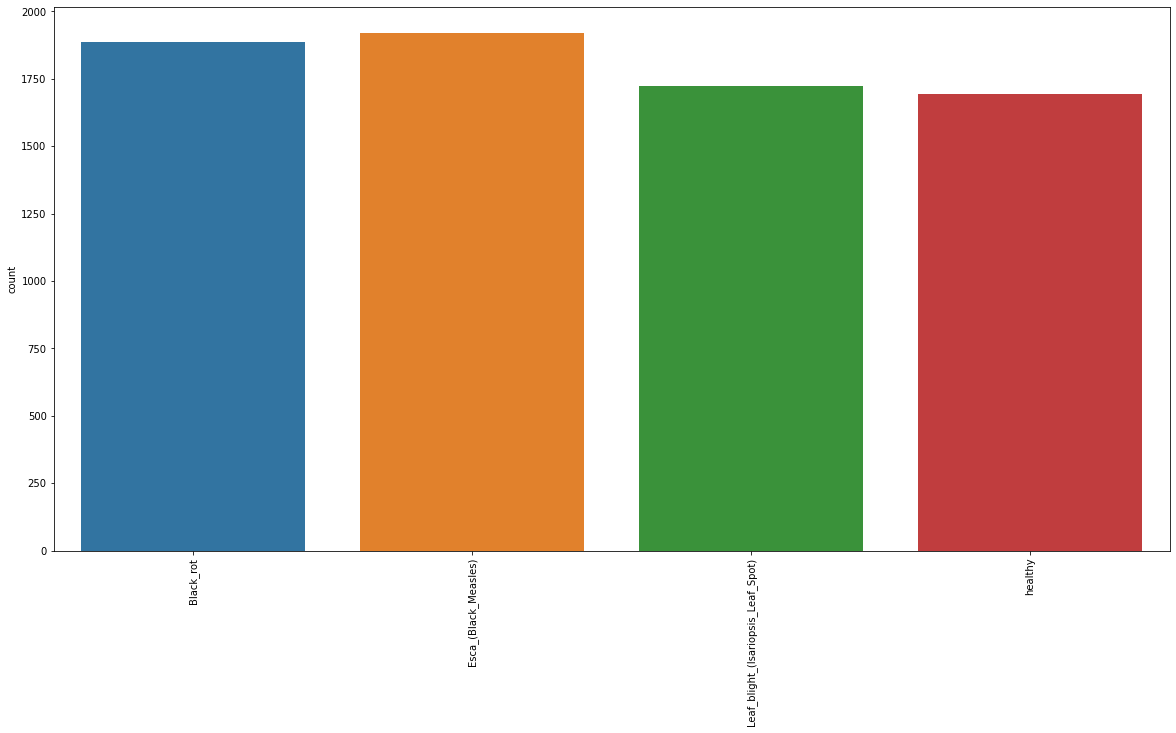

In [ ]:
import seaborn as sns

plt.figure(figsize=(20, 10))

sns.countplot(y_train0)
plt.xticks(rotation=90);

In [ ]:
pd.DataFrame(y_train0).value_counts()

Esca_(Black_Measles)                  1920
Black_rot                             1888
Leaf_blight_(Isariopsis_Leaf_Spot)    1722
healthy                               1692
dtype: int64

## Preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y_train = encoder.fit_transform(y_train0)
y_valid = encoder.transform(y_valid0)

In [ ]:
# Pour retrouver facilement les noms des labels
dict_maladie_Grape = { 0: 'Black_rot' ,
                 1: 'Black_Measles' ,
                 2 : 'healthy',
                 3 : 'Leaf_blight' }

list_maladie_Grape =[ 'Black_rot' ,'Black_Measles' ,'healthy', 'Leaf_blight' ]



In [ ]:
# Shape of X_train and y_train
print('Shape of X Train:', X_train.shape)
print('Shape of y train:',y_train.shape)

print('Shape of X valid:', X_valid.shape)
print('Shape of y valid:',y_valid.shape)

Shape of X Train: (7222, 100, 100, 3)
Shape of y train: (7222,)
Shape of X valid: (1805, 100, 100, 3)
Shape of y valid: (1805,)


In [ ]:
pd.DataFrame(y_train).value_counts()

1    1920
0    1888
2    1722
3    1692
dtype: int64

## Callbacks

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 8,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=2,
                            mode='min')

## Generateur de donnees

In [ ]:
train_data_generator = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=1,
        height_shift_range=1,
        zoom_range=[0.7, 1.2],
        horizontal_flip=True)

test_data_generator = ImageDataGenerator()

In [ ]:
batch_size = 50

training_data = train_data_generator.flow(X_train, y_train, batch_size=batch_size)
test_data = test_data_generator.flow(X_valid, y_valid, batch_size=batch_size)

# 1er Modele: Architecture LeNet avec generateur d'images

#### Architecture Lenet

In [ ]:
input_shape = (100,100,3)

In [ ]:
model_Grape1 = Sequential()
model_Grape1.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model_Grape1.add(MaxPooling2D(pool_size=(3, 3)))
model_Grape1.add(Dropout(rate=0.2))
model_Grape1.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model_Grape1.add(MaxPooling2D(pool_size=(2, 2)))
model_Grape1.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model_Grape1.add(MaxPooling2D(pool_size=(2, 2)))
model_Grape1.add(Dropout(rate=0.2))
model_Grape1.add(Flatten())
model_Grape1.add(Dense(units=64, activation='relu'))
model_Grape1.add(Dense(units=4, activation='sigmoid'))# 4 ?

In [ ]:
model_Grape1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_Grape1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 96, 96, 30)        2280      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 30)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 30)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 64)        17344     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 32)       

In [ ]:
history_Grape1 = model_Grape1.fit_generator(generator = training_data, 
                              epochs = 20,
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


144/144 [==============================] - 60s 415ms/step - loss: 0.8819 - accuracy: 0.6075 - val_loss: 0.4530 - val_accuracy: 0.8161 - lr: 0.0010
Epoch 2/20
144/144 [==============================] - 58s 401ms/step - loss: 0.4779 - accuracy: 0.8047 - val_loss: 0.7627 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 3/20
144/144 [==============================] - 57s 398ms/step - loss: 0.3885 - accuracy: 0.8417 - val_loss: 0.4213 - val_accuracy: 0.8244 - lr: 0.0010
Epoch 4/20
144/144 [==============================] - 57s 397ms/step - loss: 0.3496 - accuracy: 0.8634 - val_loss: 0.3358 - val_accuracy: 0.8656 - lr: 0.0010
Epoch 5/20
144/144 [==============================] - 57s 398ms/step - loss: 0.2789 - accuracy: 0.8918 - val_loss: 0.2583 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 6/20
144/144 [==============================] - 57s 397ms/step - loss: 0.2405 - accuracy: 0.9045 - val_loss: 0.2222 - val_accuracy: 0.9122 - lr: 0.0010
Epoch 7/20
144/144 [==============================] - 56s 389ms

In [ ]:
model_Grape1.save('/content/drive/MyDrive/model_Grape1_Healthy')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_Grape1_Healthy/assets


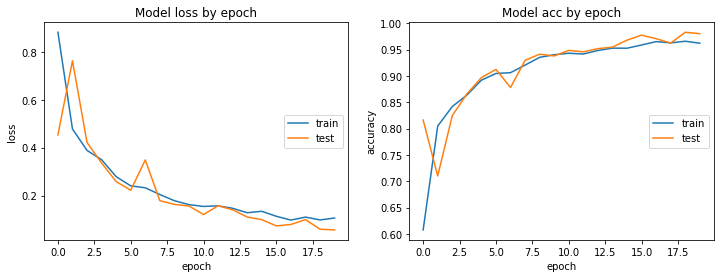

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Grape1.history['loss'])
plt.plot(history_Grape1.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_Grape1.history['accuracy'])
plt.plot(history_Grape1.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
test_pred_Grape1 = model_Grape1.predict(X_valid)

test_pred_Grape1_class = test_pred_Grape1.argmax(axis = 1)

In [ ]:

test_pred_Grape1_label = encoder.inverse_transform(test_pred_Grape1_class)
y_valid_label =encoder.inverse_transform( y_valid)

In [ ]:
print(metrics.classification_report(y_valid_label, test_pred_Grape1_label))

                                    precision    recall  f1-score   support

                         Black_rot       0.98      0.94      0.96       472
              Esca_(Black_Measles)       0.96      0.99      0.97       480
Leaf_blight_(Isariopsis_Leaf_Spot)       0.98      1.00      0.99       430
                           healthy       1.00      1.00      1.00       423

                          accuracy                           0.98      1805
                         macro avg       0.98      0.98      0.98      1805
                      weighted avg       0.98      0.98      0.98      1805



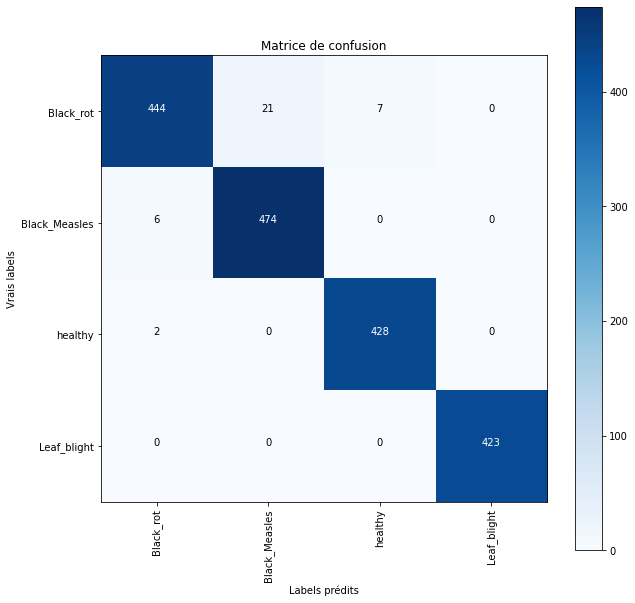

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_Grape1_label)

classes = range(0,4)
plt.figure(figsize=(10, 10))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.yticks([0,1,2, 3], list_maladie_Grape )
plt.ylabel('Vrais labels')
plt.xticks([0,1,2, 3],list_maladie_Grape,
                  rotation = 90)

plt.xlabel('Labels prédits')

plt.show()